In [1]:
topK = 10

In [2]:
T = 10

In [3]:
import numpy as np
import pandas as pd
import math
# import optimization as opt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import random
import pickle
import json
import time
import copy
from tqdm import tqdm
from joblib import Parallel, delayed
import sys
# import numba as nb

**Just checking if we are running on the right server**

In [4]:
!hostname

hcdmg2


In [5]:
VERBOSITY = 0.05

def verbose(arg):
    if random.random() < VERBOSITY:
        print(arg)

verbose("echo")

In [6]:
user_train = np.load('zhendong/data/lastfm/user_train.npy')
user_test = np.load('zhendong/data/lastfm/user_test.npy')
user_valid = np.load('zhendong/data/lastfm/user_valid.npy')

In [7]:
df = pd.read_csv('zhendong/data/lastfm/interaction.csv')

In [8]:
interactions = df.values

In [9]:
len(user_train), len(user_test), len(user_valid)

(1441, 180, 180)

In [10]:
item_dict = json.load(open('zhendong/data/lastfm/Graph_generate_data/item_dict.json', 'rb'))

In [11]:
num_users = len(user_train)+len(user_test)+ len(user_valid)
num_items = len(item_dict)
num_features = 35

In [12]:
item_dict

{'0': {'categories': [73, 79], 'feature_index': [2, 3], 'busi_id': 11547},
 '1': {'categories': [73, 81, 79],
  'feature_index': [2, 4, 3],
  'busi_id': 11548},
 '2': {'categories': [73, 81, 754],
  'feature_index': [2, 4, 5],
  'busi_id': 11549},
 '3': {'categories': [103, 754, 167, 625],
  'feature_index': [6, 5, 7, 8],
  'busi_id': 5988},
 '4': {'categories': [83, 754], 'feature_index': [11, 5], 'busi_id': 15267},
 '5': {'categories': [24, 73, 81, 79, 185],
  'feature_index': [10, 2, 4, 3, 12],
  'busi_id': 10613},
 '6': {'categories': [73, 79, 61],
  'feature_index': [2, 3, 14],
  'busi_id': 6794},
 '7': {'categories': [73, 754], 'feature_index': [2, 5], 'busi_id': 6795},
 '8': {'categories': [181, 24, 73, 79],
  'feature_index': [15, 10, 2, 3],
  'busi_id': 6792},
 '9': {'categories': [24, 73, 81, 83, 79, 754, 184, 191, 16, 25, 352],
  'feature_index': [10, 2, 4, 11, 3, 5, 16, 17, 18, 19, 20],
  'busi_id': 6790},
 '10': {'categories': [73, 16], 'feature_index': [2, 18], 'busi_id':

In [13]:
item_opinion = np.zeros((num_items, num_features))

for i in item_dict:
    features = list(map(int,item_dict[i]['feature_index']))
    item_opinion[int(i),features] = 1

In [14]:
item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [15]:
user_attr = json.load(open('zhendong/data/lastfm/user_attr.json', 'rb'))

In [16]:
user_attr

{'0': [1, 0, 10, 3, 19, 20, 24],
 '1': [3, 2, 1, 20, 12, 18, 9],
 '2': [3, 2, 4, 22, 23, 0, 15],
 '3': [5, 8, 19, 7, 22, 10, 20],
 '4': [5, 10, 7, 24, 6, 21, 2],
 '5': [10, 5, 8, 22, 7, 9, 2],
 '6': [10, 2, 5, 13, 14, 9, 20],
 '7': [3, 4, 2, 23, 12, 22, 17],
 '8': [5, 10, 2, 20, 24, 7, 1],
 '9': [2, 3, 5, 12, 21, 10, 13],
 '10': [10, 5, 21, 1, 2, 24, 4],
 '11': [27, 31, 8, 2, 9, 17, 5],
 '12': [2, 28, 10, 19, 0, 4, 22],
 '13': [10, 5, 2, 1, 7, 6, 13],
 '14': [5, 10, 2, 1, 3, 24, 4],
 '15': [2, 9, 20, 3, 30, 12, 0],
 '16': [21, 29, 15, 11, 28, 25, 0],
 '17': [10, 5, 24, 1, 21, 2, 16],
 '18': [13, 32, 29, 3, 21, 2, 5],
 '19': [3, 2, 20, 19, 22, 16, 15],
 '20': [5, 10, 2, 0, 21, 4, 16],
 '21': [10, 5, 24, 7, 6, 1, 2],
 '22': [2, 13, 9, 27, 19, 0, 15],
 '23': [10, 3, 2, 1, 5, 17, 20],
 '24': [10, 19, 18, 25, 3, 24, 2],
 '25': [5, 10, 2, 21, 7, 3, 24],
 '26': [5, 10, 2, 24, 1, 22, 3],
 '27': [10, 19, 25, 1, 18, 20, 5],
 '28': [3, 2, 4, 17, 10, 30, 20],
 '29': [2, 3, 17, 13, 9, 10, 19],
 '30

In [17]:
user_opinion = np.zeros((num_users, num_features))

for u in user_attr:
    features = list(map(int,user_attr[u]))
    user_opinion[int(u),features] = 1

In [18]:
user_opinion

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [19]:
train_interaction = []
test_interaction = []
val_interaction = []

train_review = []
test_review = []
val_review = []

for u, i in interactions:
    if u in user_train:
        train_interaction.append([u, i])
        train_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))
    elif u in user_valid:
        val_interaction.append([u, i])
        val_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

    elif u in user_test:
        test_interaction.append([u, i])
        test_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

train_user_interaction = np.array(train_interaction)
test_user_interaction = np.array(test_interaction)
val_user_interaction = np.array(val_interaction)

train_review = np.array(train_review)
test_review = np.array(test_review)
val_review = np.array(val_review)

In [20]:
train_user_interaction

array([[1026,  531],
       [1502, 5113],
       [1531, 3661],
       ...,
       [ 286, 2034],
       [ 689,  160],
       [ 170, 3967]])

In [21]:
train_review

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [22]:
item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [23]:
!pwd

/u/ah3wj/CRS/FacT-CRS/unicorn


In [24]:
def visualize_hit(user_interaction, review):
    item_hit = np.full(num_items, 0)
    user_hit = np.full(num_users, 0)
    feature_hit = np.full(num_features, 0)

    for review_id in range(len(user_interaction)):
        u, i = user_interaction[review_id]
        item_hit[i] += 1
        user_hit[u] += 1

        single_review = review[review_id]
        idx = np.where(single_review == 1)
        feature_hit[idx] += 1
    print("ITEM")
    print(item_hit.mean(), item_hit.std())
    plt.plot(item_hit)
    plt.show()
    
    print("USER")
    print(user_hit.mean(), user_hit.std())
    plt.plot(user_hit)
    plt.show()
    
    print("FEATURES")
    plt.plot(feature_hit)
    plt.show()
    
    return user_hit, item_hit, feature_hit

ITEM
7.750269106566201 41.95080237166129


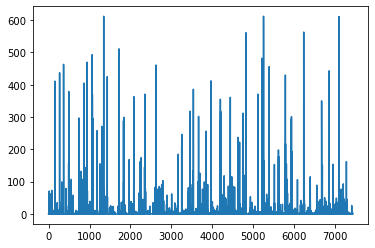

USER
31.98223209328151 16.01331052789318


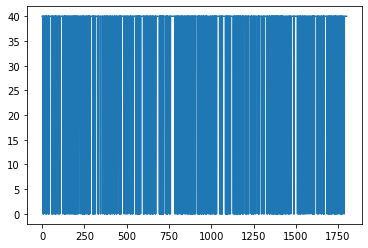

FEATURES


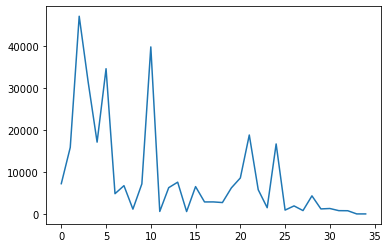

In [25]:
user_hit, item_hit, feature_hit = visualize_hit(user_interaction = train_user_interaction, review=train_review)

ITEM
0.9687836383207751 5.048456768487228


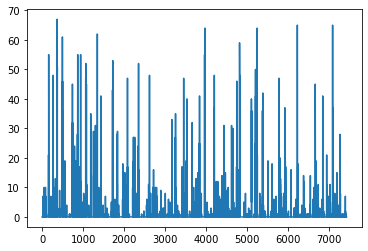

USER
3.997779011660189 11.99703811114797


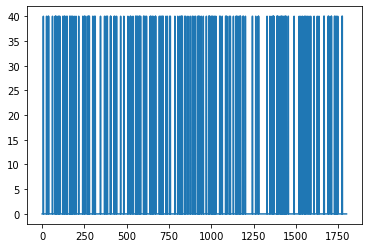

FEATURES


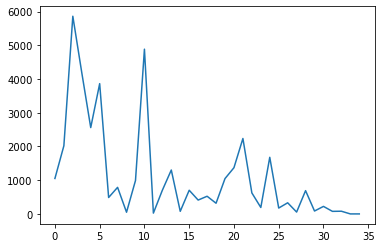

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1051, 2021, 5863, 4190, 2561, 3864,  487,  788,   50,  990, 4886,
          24,  701, 1302,   77,  702,  411,  524,  317, 1048, 1371, 2237,
         623,  191, 1679,  174,  330,   55,  690,   86,  223,   76,   80,
           0,    0]))

In [26]:
visualize_hit(user_interaction = test_user_interaction, review=test_review)

In [27]:
def get_item_opinion():
#     op = np.zeros((num_items, num_features))
#     for rid in range(len(train_user_interaction)):
#         _, i = train_user_interaction[rid]
#         features = train_review[rid]!=1
#         op[i, features] += 1
    op = np.zeros((num_items, num_features))

    for i in item_dict:
        features = list(map(int,item_dict[i]['feature_index']))
        op[int(i),features] += 1
#     row_sums = op.sum(axis=1)
#     new_matrix = op / row_sums[:, np.newaxis]
#     new_matrix[np.isnan(new_matrix)] = 0
    return op

train_item_opinion = get_item_opinion()
train_item_opinion

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [28]:
item_opinion.max(), train_item_opinion.max()

(1.0, 1.0)

In [29]:
def loadSUV(i):
    SU = np.load('lastfm-SU-{}.npy'.format(i))
    V = np.load('lastfm-V-{}.npy'.format(i))
    return SU, V

def saveSUV(i):
    np.save('lastfm-SU-{}'.format(i), SU)
    np.save('lastfm-V-{}'.format(i), V)

In [36]:
# saveSUV(i=40)
SU, V = loadSUV(i=40)

# SU.shape

In [37]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0, max_iter = 500)
# SU = model.fit_transform(train_review)
# H = model.components_
# SU.shape
# SU

In [32]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0, max_iter = 200)
# V = model.fit_transform(item_opinion)
# H = model.components_
# V.shape
# V

### Let's calculate sr@1 first

In [33]:
### Let's calculate MR@1 first
def MRR1(SU, V, user_interaction):
    mrr = 0
    success = 0
    count = 0
    for review_id in np.random.choice(len(user_interaction), size = 5000):
        count += 1
        u, i = user_interaction[review_id]
        pred = -SU[review_id].dot(V.T)
#         sur = SU[review_id]
#         pred = np.sum(np.abs((Vr-sur))**2,axis=-1)

        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

    print(mrr/(count), success/(count))


In [38]:
MRR1(SU, V, train_user_interaction)

21.12 0.548
20.862 0.558
20.320333333333334 0.5566666666666666
20.349 0.5595
20.6792 0.5552
20.6792 0.5552


# Learn SU and V simultaneously

In [34]:
V.max()

2.930763056209065

In [35]:
def get_rating_matrix():
    r = np.zeros((num_users, num_items))
    for u, i in train_user_interaction:
        r[u, i] = 1
    return r
rating_matrix = get_rating_matrix()
rating_matrix.sum()

57600.0

In [36]:
np.max(SU), np.max(V)

(4.615262070502254, 2.930763056209065)

In [37]:
# sr1(SU = SU, V=V, user_interaction = train_user_interaction)
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

20.239 0.538
21.6755 0.5365
21.723 0.5363333333333333
21.57975 0.54125
21.2874 0.5412
21.2874 0.5412


In [67]:
# Learn SU and V simultaneously
lambda_BPR = 0.1

num_SGDUpdate = len(train_user_interaction)

alpha = 0.001
beta = 0.01


ALPHA = 0.01
BETA = 0.01

assert ALPHA >= alpha

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sgd_update_SUV_rating(SU, V, num_iter, num_BPRpairs):
    
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            # Update user and item latent feature matrices
            sig = sigmoid(pred)
            e = 1-sig
        
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]

#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]


            not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
    
            for i in np.random.choice(not_rated_items, num_BPRpairs):
                pred = SU[review_id].dot(V[i].T)
                # Update user and item latent feature matrices
                sig = sigmoid(pred)
                e = 0-sig
                SU[review_id, :] +=  lambda_BPR*(ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:])
                V[i, :] += lambda_BPR*(ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:])
    
    return SU, V

In [108]:
SU, V = sgd_update_SUV_rating(SU, V, num_iter=10, num_BPRpairs = 5)

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.17s/it]


In [109]:
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

385.904 0.127
388.143 0.1275
391.12966666666665 0.12833333333333333
394.749 0.12225
392.4162 0.1202
392.4162 0.1202


In [110]:
def MRR5(model, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
    
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))
    
    return success/count

In [111]:
# SUold = copy.deepcopy(SU)

In [112]:
# SU, V = loadSUV(i  = 0)

In [113]:
# MRR5(model = dt, V = V, user_interaction=train_user_interaction, reviews=train_review)

In [114]:
# MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)

# --------------------- Personalization -------------------------------------------

In [39]:
def sgd_update_SU(SU, V, num_iter):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1-sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  SU

In [40]:
def sgd_update_V(SU, V, num_iter, num_review):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_review):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1 - sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  V

In [41]:
def personalize(model, num_iter, num_review):
    SU_copy = copy.deepcopy(SU)
    
    V_predict = model.predict(item_opinion)
    V_predict= sgd_update_V(SU = SU_copy, V = V_predict, num_iter = num_iter, num_review = num_review)

#     SU_predict, V_copy = sgd_update_SUV_rating(SU = SU_predict, V = V_copy, num_iter = num_iter)
    
#     bpr_update_SUV_rating(SU = SU_predict, V = V_copy, num_BPRpairs = 10000)
    
    return SU_copy, V_predict



## Loop this 

In [42]:
from sklearn.ensemble import RandomForestRegressor as RF

In [43]:

def DTCRS(model, V, user_interaction, reviews):
    tc = 0
    success = 0
    count = 0
    mrr = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
    #         print("target:", i, "recommend:", recommend)
    #         time.sleep(1)
        rank = np.where(recommend == i)[0][0]

        mrr += (rank+1)

        if ( rank < (T - depth)*10): # success
            tc += depth + (rank //10)  + 1
            success += 1
        else: # failed
            tc += T

        if((count) % 1000 == 0):
            print(mrr/(count), tc/count, success/(count))
    return success/(count)

# DTCRS(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)


In [147]:

val_sr = 0
for i in range(20):
    Vold = copy.deepcopy(V)
    dtitem = RF(max_depth = 10)
    dtitem.fit(item_opinion, V)
    _, V = personalize(dtitem, 150, len(train_user_interaction))
    SU, V = sgd_update_SUV_rating(SU, V, num_iter=30, num_BPRpairs = 5)
    print("norm diff:", ((V-Vold)**2).sum())
    
    depth = 5
    from sklearn.tree import DecisionTreeRegressor as DT
    dt = DT(max_depth = depth)
    dt.fit(train_review, SU)
    
    print("single rec:", MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review))
    
    print("MRR1:")
    MRR1(SU = SU, V=V, user_interaction = train_user_interaction)
    
    new_val_sr = DTCRS(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)
    print("new validation success rate:", new_val_sr)
    
    if(new_val_sr < val_sr):
        V = Vold
        break
    else:
        val_sr = new_val_sr
    

100%|███████████████████████████████████████████| 30/30 [05:05<00:00, 10.19s/it]


norm diff: 3029.366459764516
232.605 0.158
215.9755 0.1615
221.79433333333333 0.15066666666666667
224.10575 0.1535
223.9022 0.155
221.61016666666666 0.15733333333333333
218.48228571428572 0.15757142857142858
single: 0.15666666666666668
MRR1:
123.699 0.339
125.0815 0.3505
122.26033333333334 0.345
121.261 0.34275
118.879 0.3504
118.879 0.3504
232.605 8.905 0.402
215.9755 8.8995 0.404
221.79433333333333 8.928333333333333 0.401
224.10575 8.92275 0.401
223.9022 8.9238 0.401
221.61016666666666 8.9195 0.4008333333333333
218.48228571428572 8.913142857142857 0.40185714285714286
new validation success rate: 0.40194444444444444


100%|███████████████████████████████████████████| 30/30 [05:10<00:00, 10.34s/it]


norm diff: 1521.097397659236
138.37 0.202
129.324 0.207
131.006 0.196
134.49625 0.19925
134.1048 0.2008
131.09133333333332 0.20183333333333334
129.08471428571428 0.2027142857142857
single: 0.20305555555555554
MRR1:
45.623 0.45
45.055 0.44
44.74966666666667 0.43966666666666665
45.09875 0.44425
44.1918 0.4422
44.1918 0.4422
138.37 8.481 0.595
129.324 8.492 0.583
131.006 8.532666666666668 0.5746666666666667
134.49625 8.52675 0.5715
134.1048 8.5266 0.571
131.09133333333332 8.517833333333334 0.5728333333333333
129.08471428571428 8.505714285714285 0.5768571428571428
new validation success rate: 0.5766666666666667


100%|███████████████████████████████████████████| 30/30 [05:08<00:00, 10.28s/it]


norm diff: 787.3081225496383
120.867 0.228
113.389 0.229
114.31866666666667 0.21666666666666667
117.493 0.21775
117.723 0.2196
114.75666666666666 0.22116666666666668
113.002 0.22228571428571428
single: 0.22194444444444444
MRR1:
22.547 0.523
23.777 0.5105
24.319 0.5136666666666667
25.14275 0.5095
24.8328 0.508
24.8328 0.508
120.867 8.34 0.639
113.389 8.345 0.6225
114.31866666666667 8.387666666666666 0.616
117.493 8.3825 0.61275
117.723 8.3818 0.6116
114.75666666666666 8.3725 0.6135
113.002 8.362285714285715 0.6162857142857143
new validation success rate: 0.6154166666666666


100%|███████████████████████████████████████████| 30/30 [05:11<00:00, 10.38s/it]


norm diff: 433.2272108646491
117.012 0.233
109.232 0.23
110.56 0.21833333333333332
113.43375 0.2195
114.4084 0.2218
111.7575 0.22283333333333333
109.64942857142857 0.22371428571428573
single: 0.22333333333333333
MRR1:
22.252 0.517
22.066 0.538
21.773 0.5363333333333333
21.99975 0.53375
22.1052 0.5288
22.1052 0.5288
117.012 8.314 0.649
109.232 8.3295 0.6285
110.56 8.370666666666667 0.621
113.43375 8.36625 0.61875
114.4084 8.3672 0.6168
111.7575 8.360666666666667 0.6186666666666667
109.64942857142857 8.35057142857143 0.6208571428571429
new validation success rate: 0.6201388888888889


100%|███████████████████████████████████████████| 30/30 [05:07<00:00, 10.25s/it]


norm diff: 269.9562111167954
115.707 0.23
107.507 0.23
108.70333333333333 0.21966666666666668
111.56425 0.21975
112.9318 0.2212
110.274 0.22166666666666668
108.079 0.22142857142857142
single: 0.22125
MRR1:
20.691 0.532
21.1015 0.5245
21.002 0.5336666666666666
20.917 0.53175
20.854 0.5316
20.854 0.5316
115.707 8.331 0.642
107.507 8.329 0.6275
108.70333333333333 8.366 0.6206666666666667
111.56425 8.36025 0.61925
112.9318 8.3598 0.6158
110.274 8.354333333333333 0.6176666666666667
108.079 8.345 0.6195714285714286
new validation success rate: 0.6190277777777777


In [121]:
# rf = RF(max_depth = depth)
# rf.fit(train_review, SU)
# MRR5(model = rf, V = V, user_interaction=test_user_interaction, reviews=test_review)

## end loop
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Super User FacT

In [42]:
train_review.shape

(57600, 35)

In [44]:
class Node:
    def __init__(self, parent, vector, members, used_features):
        self.parent = parent
        self.vector = vector
        self.members = members        
        self.used_features = used_features
        
        self.feature = None
        self.pos_node = None
        self.neg_node = None
#         self.unknown_node = None
        
        self.error = np.inf
        

In [45]:
PARTIAL = 0.9





class Tree:
    def __init__(self, tree_type):
        assert tree_type in ["review", "item"]
        self.tree_type = tree_type
        if(self.tree_type == "review"):
            root_error, root_vector = fit(idx = np.array(range(len(train_user_interaction))), 
                                          training_type = tree_type,
                                          node_vector = np.mean(SU, axis=0), 
                                          SU = SU, V = V, num_iter=num_FIT, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.random.choice(len(train_user_interaction), int(PARTIAL * len(train_user_interaction))), used_features = [])
            self.root.error = root_error

        elif(self.tree_type == "item"):
            root_error, root_vector = fit(idx = np.array(range(num_items)), 
                                          training_type = tree_type,
                                          node_vector = np.mean(V, axis=0), 
                                          SU = SU, V = V, num_iter=0, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.array(range(num_items)), used_features = [])
            self.root.error = root_error
        else:
            raise ValueError("Invalid tree type")
        
#         review_tree_condition = (tree_type == "review" and len(self.root.members) == len(train_user_interaction))
#         item_tree_condition = (tree_type == "item" and len(self.root.members) == num_items)
        
#         assert review_tree_condition or item_tree_condition        

In [46]:
def squared_error_and_mse(true, pred):
    '''I am assuming true and pred both to be 1-D array'''
    assert pred.ndim == 1
    error = ((true - pred)**2).sum()
    return error, error/len(pred)

In [47]:
def sgd_update_review_vector(single_vector, V, review_indices, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in (review_indices):
            u, i = train_user_interaction[review_id]
            pred = sigmoid(single_vector.dot(V[i].T))
            e = 1 - pred ## note single vector being used in prediction
            single_vector += ALPHA *  (e * V[i, :] -  BETA * single_vector)
            
            error += np.log(e)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR * ALPHA *  (e * V[i, :] -  BETA * single_vector)
#                 error += e

                
    return single_vector, error/num_iter

In [48]:
def sgd_update_item_vector(SU, single_vector, item_indices, review_idx, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in review_idx:
            u, i = train_user_interaction[review_id]
            pred = sigmoid(SU[review_id].dot(single_vector.T))
            e = 1 - pred ## note review_id being used in prediction
            
            error += e
            # Update user and item latent feature matrices
            single_vector += ALPHA * (e * SU[review_id] - BETA * single_vector)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR*ALPHA * (e * SU[review_id] - BETA * single_vector)
#                 error += e
                
    return single_vector, error

In [49]:
def fit(idx, training_type, node_vector, SU, V, num_iter, num_BPRpairs):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if idx is None or (len(idx) == 0):
        return 0, None
    
    single_vector = copy.deepcopy(node_vector) ## we don't want to change node vector yet
    
    if training_type == "review":
        single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
        single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    return error, single_vector

In [50]:

# SUmean = np.zeros_like(SU)
# e, su = fit(idx = np.array(range(len(train_user_interaction))), 
#                                           training_type = "review",
#                                           node_vector = np.mean(SU, axis=0), 
#                                           SU = SU, V = V, num_iter = 5, num_BPRpairs=1)
# SUmean = SUmean + su
# SUmean, e

In [51]:
# MRR1(SU = SUmean, V=V, user_interaction = train_user_interaction)

# -----------------------------------------------------------------------------------------

In [52]:
# @nb.njit(parallel=True)
# def var_nb(a, ddof=0):
#     n = len(a)
#     s = a.sum()
#     m = s / (n - ddof)
#     v = 0
#     for i in nb.prange(n):
#         v += (a[i] - m) ** 2
#     return v / (n - ddof)

In [53]:
def get_error(idx, training_type):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if (len(idx) == 0):
        return 0
    
    
    if training_type == "review":
#         single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
#         single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    
    error = ((SU[review_idx, :] - SU[review_idx, :].mean(axis = 0))**2).sum()
#     error = SU[review_idx, :].var()

    return error

# -----------------------------------------------------------------------------------------

In [54]:
VERBOSE = 0.4

def find_best_split(node, training_type, flist):    
    '''
    I will assume node.members is non-empty
    if training_type == review => we are updating SU keeping V fixed
    if training_type == item => we are updating V keeping SU fixed
    '''
    if node.members is None or len(node.members) == 0:
        node = None
        return None
    members = node.members
    
    assert training_type in ["review", "item"]
    if(training_type == "review"):
        opinion_matrix = train_review
    elif(training_type == "item"):
        opinion_matrix = train_item_opinion
        
    
    
    
    best_feature = None
    lowest_avg_error = np.inf
    lowest_pos_error = np.inf
    lowest_neg_error = np.inf

    best_pos_members = None
    best_neg_members = None
    
    best_pos_single_vector = None
    best_neg_single_vector = None
    
    
    for feature in flist:
        
        if (feature in node.used_features):
            continue
            
        pos_idx = []
        neg_idx = []
        
        for r in node.members:
            val = opinion_matrix[r, feature]
            if(val > 0):
                pos_idx.append(r)
            else:
                neg_idx.append(r)

        pos_idx = np.array(pos_idx)
        neg_idx = np.array(neg_idx)
        
        assert len(pos_idx) + len(neg_idx)  == len(node.members)
        
        pos_error, pos_single_vector  = fit(idx = pos_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        neg_error, neg_single_vector = fit(idx = neg_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        
#         pos_error = get_error(idx = pos_idx, training_type = training_type)  #must use the fit method to get error
#         neg_error = get_error(idx = neg_idx, training_type = training_type)
        
        w_pos = 1 #len(pos_idx)/len(members)
        w_neg = 1 #len(neg_idx)/len(members)
        
        
        avg_error = w_pos*pos_error + w_neg*neg_error
        
        if (random.random() < VERBOSE):
            print("feature {} avg. error: {}, ratio: {}, pos:{}, neg: {}".format(feature,  avg_error, len(pos_idx)/len(members), len(pos_idx), len(neg_idx)))
        
        ## Update carefully:
        if(avg_error < lowest_avg_error):
            
            lowest_avg_error = avg_error
            best_feature = feature
            
            lowest_pos_error = pos_error
            lowest_neg_error = neg_error
            
            best_pos_members = pos_idx
            best_neg_members = neg_idx

    node.used_features.extend([best_feature])
    
    lowest_pos_error, best_pos_single_vector  = fit(idx = best_pos_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    lowest_neg_error, best_neg_single_vector = fit(idx = best_neg_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    
    
    return (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector)

In [56]:
# review_tree = Tree(tree_type = "review")
# review_tree.root.vector

In [57]:
# review_tree.root.feature

In [58]:
# itmset = set(train_user_interaction[review_tree.root.members,1])
# GINI = 1
# if(len(review_tree.root.members) > 0):
#     GINI -= (len(itmset)/len(review_tree.root.members))**2
#     print(GINI)

# -----------------------------------------------------------------------------------------

In [59]:
def create_tree(tree_type, node, depth, flist):
    if (depth > MAX_DEPTH):
        print("MAX DEPTH REACHED: {}".format(MAX_DEPTH))
        return
    
    if (node.feature is None):
        best = find_best_split(node = node, training_type = tree_type, flist = flist)
        
#         print(best)
        
        if best is None:
            print("best is none")
            return
        
        
        ## early stopping GINI Index
#         itmset = set(train_user_interaction[node.members,1])
#         GINI = 1
#         if(len(node.members) > 0):
#             GINI -= (len(itmset)/len(node.members))**2
#         if (GINI > 0.9967):
#             return
            
        
        
        
        (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector) = best
        node.feature = best_feature
        
        
        
        
        node.error = lowest_pos_error + lowest_neg_error #lowest_avg_error
        
        node.pos_node = Node(parent = node, vector = best_pos_single_vector, members = best_pos_members, used_features = node.used_features.copy())
        node.neg_node = Node(parent = node, vector = best_neg_single_vector, members = best_neg_members, used_features = node.used_features.copy())

    else:
        print("CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................")
    
    
    print("depth: {}, best feature id:{}, error:{}".format(depth, node.feature, node.error))    

    print("# of pos members: ", 0 if node.pos_node.members is None else len(node.pos_node.members))
    print('# of neg members: ', 0 if node.neg_node.members is None else len(node.neg_node.members))

    create_tree(tree_type = tree_type, node = node.pos_node, depth = depth +1, flist = flist)

    create_tree(tree_type = tree_type, node = node.neg_node, depth = depth +1, flist = flist)


In [60]:
MAX_DEPTH = 3

In [62]:

num_iter_review = 1
num_iter_item = 1

num_FIT = 20

# create_tree(tree_type = 'review', node = review_tree.root, depth=0, flist = list(range(num_features)))


# np.save('zlastfm-review-tree-40.npy', review_tree)

In [63]:
print("Done!!")

Done!!


In [64]:
N_TREE = 10
prob = 0.9

def sub_features():
    f = []
    for _ in range(N_TREE):
        l = []
        for i in range(num_features):
            if(random.random() < prob):
                l.append(i)
        
        f.append(l)
        
    return f


# subflist = sub_features()
subflist

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  21,
  22,
  23,
  24,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  22,
  23,
  24,
  25,
  27,
  29,
  30,
  31,
  32,
  33,
  34],
 [1,
  2,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  31,
  32,
  34],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  11,
  12,
  14,
  15,
  16,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34],
 [2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  1

In [68]:
# forest = [ Tree(tree_type = "review") for _ in range(N_TREE)] ## don't overwrite the forest

In [69]:
# [par_forest(i) for i in range(N_TREE)]
# @nb.jit(parallel=True)
# def par_forest(i):
# #     for i in nb.prange(N_TREE):

    

#     return None

# par_forest()

# Parallel(n_jobs=10)(delayed (par_forest)(i) for i in range(N_TREE))

for i in range(N_TREE):
    print("===============================")
    print("Starting building Tree", i)
    print("===============================")

    create_tree(tree_type="review", node=forest[i].root, depth=0, flist = subflist[i])
    print("===============================")
    print("Finished building Tree", i)
    print("===============================")


Starting building Tree 0
feature 0 avg. error: -168138.71774869433, ratio: 0.12561728395061728, pos:6512, neg: 45328
feature 1 avg. error: -173700.08480349212, ratio: 0.27337962962962964, pos:14172, neg: 37668
feature 2 avg. error: -185342.85175167027, ratio: 0.8201774691358025, pos:42518, neg: 9322
feature 5 avg. error: -192495.9903937606, ratio: 0.5966435185185185, pos:30930, neg: 20910
feature 8 avg. error: -164990.68031710683, ratio: 0.019232253086419755, pos:997, neg: 50843
feature 13 avg. error: -173888.3797999652, ratio: 0.13215663580246914, pos:6851, neg: 44989
feature 14 avg. error: -166619.26744576544, ratio: 0.008777006172839507, pos:455, neg: 51385
feature 15 avg. error: -168059.63198010492, ratio: 0.11354166666666667, pos:5886, neg: 45954
feature 17 avg. error: -164866.00630528372, ratio: 0.048977623456790124, pos:2539, neg: 49301
feature 19 avg. error: -167875.94279171625, ratio: 0.10823688271604938, pos:5611, neg: 46229
feature 22 avg. error: -165953.02443324024, ratio: 

feature 24 avg. error: -71304.38409491512, ratio: 0.6704497177884323, pos:11047, neg: 5430
feature 30 avg. error: -69596.8195757168, ratio: 0.0021241730897614856, pos:35, neg: 16442
feature 32 avg. error: -69564.31625771073, ratio: 0.0010924318747344785, pos:18, neg: 16459
feature 33 avg. error: -69501.67702484266, ratio: 0.0, pos:0, neg: 16477
feature 34 avg. error: -69501.67702484266, ratio: 0.0, pos:0, neg: 16477
depth: 2, best feature id:24, error:-71927.13465913358
# of pos members:  11047
# of neg members:  5430
feature 0 avg. error: -51000.45525513618, ratio: 0.020729609848827737, pos:229, neg: 10818
feature 2 avg. error: -51712.55397694474, ratio: 0.6834434688150629, pos:7550, neg: 3497
feature 7 avg. error: -51117.228097870495, ratio: 0.43396397211912735, pos:4794, neg: 6253
feature 9 avg. error: -51053.248364989086, ratio: 0.02353580157508826, pos:260, neg: 10787
feature 11 avg. error: -51063.13156260163, ratio: 0.0005431338825020367, pos:6, neg: 11041
feature 14 avg. error: 

feature 16 avg. error: -23108.043061143777, ratio: 0.026124197002141327, pos:183, neg: 6822
feature 17 avg. error: -23218.986141431793, ratio: 0.1578872234118487, pos:1106, neg: 5899
feature 18 avg. error: -23200.89368384787, ratio: 0.06038543897216274, pos:423, neg: 6582
feature 19 avg. error: -23965.941226081995, ratio: 0.3127765881513205, pos:2191, neg: 4814
feature 24 avg. error: -23320.57055931261, ratio: 0.050107066381156314, pos:351, neg: 6654
feature 26 avg. error: -23622.7150598642, ratio: 0.16473947180585297, pos:1154, neg: 5851
feature 27 avg. error: -23142.40863412155, ratio: 0.048822269807280515, pos:342, neg: 6663
feature 29 avg. error: -23478.57368287887, ratio: 0.07109207708779443, pos:498, neg: 6507
depth: 2, best feature id:2, error:-25835.718871971367
# of pos members:  4937
# of neg members:  2068
feature 6 avg. error: -18749.086034268246, ratio: 0.01741948551752076, pos:86, neg: 4851
feature 9 avg. error: -19081.438936408595, ratio: 0.37148065626898924, pos:1834, n

feature 31 avg. error: -59100.60756382369, ratio: 0.006765296260501078, pos:91, neg: 13360
feature 33 avg. error: -59096.59573094343, ratio: 0.0, pos:0, neg: 13451
depth: 3, best feature id:10, error:-59511.02121116273
# of pos members:  10530
# of neg members:  2921
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 0 avg. error: -4207.8049272425105, ratio: 0.26704014939309056, pos:286, neg: 785
feature 6 avg. error: -4207.0303854831445, ratio: 0.0700280112044818, pos:75, neg: 996
feature 8 avg. error: -4206.534256869337, ratio: 0.02427637721755369, pos:26, neg: 1045
feature 9 avg. error: -4205.69757450265, ratio: 0.06816059757236227, pos:73, neg: 998
feature 11 avg. error: -4207.457811447329, ratio: 0.0056022408963585435, pos:6, neg: 1065
feature 12 avg. error: -4205.358524201455, ratio: 0.08309990662931839, pos:89, neg: 982
feature 16 avg. error: -4206.066789346364, ratio: 0.04481792717086835, pos:48, neg: 1023
feature 19 avg. error: -4208.921352701391, ratio: 0.059757236227824466, p

feature 29 avg. error: -32344.10597085551, ratio: 0.00989701752039588, pos:74, neg: 7403
feature 30 avg. error: -32419.699562258727, ratio: 0.06927912264277117, pos:518, neg: 6959
depth: 3, best feature id:2, error:-32823.70026703856
# of pos members:  6593
# of neg members:  884
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 1 avg. error: -25678.306534189673, ratio: 0.17784536577557228, pos:1111, neg: 5136
feature 7 avg. error: -25449.36909741555, ratio: 0.0008003841844085161, pos:5, neg: 6242
feature 9 avg. error: -25453.110112563198, ratio: 0.1243797022570834, pos:777, neg: 5470
feature 11 avg. error: -25463.588789350444, ratio: 0.004642228269569394, pos:29, neg: 6218
feature 14 avg. error: -25503.821001683333, ratio: 0.017128221546342245, pos:107, neg: 6140
feature 17 avg. error: -25513.656432442483, ratio: 0.10196894509364494, pos:637, neg: 5610
feature 18 avg. error: -25485.08420316647, ratio: 0.04882343524891948, pos:305, neg: 5942
feature 19 avg. error: -25540.088222158443, 

depth: 2, best feature id:2, error:-66686.09049187419
# of pos members:  10473
# of neg members:  4212
feature 1 avg. error: -48102.56901893731, ratio: 0.46013558674687294, pos:4819, neg: 5654
feature 4 avg. error: -47973.66757702345, ratio: 0.09214169769884464, pos:965, neg: 9508
feature 8 avg. error: -48111.47253616979, ratio: 0.021483815525637353, pos:225, neg: 10248
feature 11 avg. error: -48107.673882691626, ratio: 0.0010503198701422706, pos:11, neg: 10462
feature 13 avg. error: -48109.815103440014, ratio: 0.0021961233648429297, pos:23, neg: 10450
feature 14 avg. error: -48105.88210637309, ratio: 0.0, pos:0, neg: 10473
feature 16 avg. error: -48086.72965558526, ratio: 0.05366179700181419, pos:562, neg: 9911
feature 17 avg. error: -48100.371619979924, ratio: 0.0018141888666093765, pos:19, neg: 10454
feature 19 avg. error: -48118.176926887725, ratio: 0.02387090613959706, pos:250, neg: 10223
feature 23 avg. error: -48103.230949154175, ratio: 0.0011458034947006588, pos:12, neg: 10461


feature 11 avg. error: -24585.812691523148, ratio: 0.0031084293289449626, pos:17, neg: 5452
feature 12 avg. error: -24566.179851606288, ratio: 0.0903272993234595, pos:494, neg: 4975
feature 15 avg. error: -24563.349271324998, ratio: 0.07825927957579082, pos:428, neg: 5041
feature 16 avg. error: -24553.523800826024, ratio: 0.04278661546900713, pos:234, neg: 5235
feature 17 avg. error: -24594.30987887585, ratio: 0.09453282135673798, pos:517, neg: 4952
feature 18 avg. error: -24573.451945662524, ratio: 0.0027427317608337905, pos:15, neg: 5454
feature 20 avg. error: -24688.564248938463, ratio: 0.37721704150667396, pos:2063, neg: 3406
feature 24 avg. error: -24576.21393529793, ratio: 0.0007313951362223441, pos:4, neg: 5465
feature 25 avg. error: -24575.074847574273, ratio: 0.0014627902724446882, pos:8, neg: 5461
feature 31 avg. error: -24577.249218643807, ratio: 0.0023770341927226183, pos:13, neg: 5456
feature 32 avg. error: -24616.60353172454, ratio: 0.06436277198756628, pos:352, neg: 5117

feature 19 avg. error: -125609.6591714055, ratio: 0.0618193465727098, pos:1930, neg: 29290
feature 20 avg. error: -125755.00953849006, ratio: 0.10361947469570788, pos:3235, neg: 27985
feature 21 avg. error: -127066.33519318642, ratio: 0.4448110185778347, pos:13887, neg: 17333
feature 23 avg. error: -125452.01764141998, ratio: 0.021524663677130046, pos:672, neg: 30548
feature 24 avg. error: -129858.5749201581, ratio: 0.4460281870595772, pos:13925, neg: 17295
feature 26 avg. error: -125394.11722964155, ratio: 0.003939782190903267, pos:123, neg: 31097
feature 30 avg. error: -125209.08331399974, ratio: 0.010922485586162716, pos:341, neg: 30879
feature 31 avg. error: -125320.1288447611, ratio: 0.009705317104420243, pos:303, neg: 30917
depth: 1, best feature id:3, error:-132046.5131199857
# of pos members:  14594
# of neg members:  16626
feature 0 avg. error: -62181.9724501666, ratio: 0.11922707962176236, pos:1740, neg: 12854
feature 4 avg. error: -62480.14327852512, ratio: 0.428189666986432

feature 25 avg. error: -20855.811352013927, ratio: 0.02025036818851252, pos:110, neg: 5322
feature 26 avg. error: -20917.025757494954, ratio: 0.0071796759941089834, pos:39, neg: 5393
feature 27 avg. error: -20894.301679970748, ratio: 0.04547128129602356, pos:247, neg: 5185
feature 32 avg. error: -20860.676713779376, ratio: 0.004970544918998527, pos:27, neg: 5405
depth: 3, best feature id:2, error:-21775.711730194183
# of pos members:  4144
# of neg members:  1288
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 1 avg. error: -72675.41875310635, ratio: 0.2227934044616877, pos:4594, neg: 16026
feature 9 avg. error: -70400.52551134862, ratio: 0.16901066925315228, pos:3485, neg: 17135
feature 10 avg. error: -75050.13039686425, ratio: 0.4492725509214355, pos:9264, neg: 11356
feature 12 avg. error: -70425.48944625603, ratio: 0.13894277400581959, pos:2865, neg: 17755
feature 14 avg. error: -70330.47152503018, ratio: 0.021193016488845782, pos:437, neg: 20183
feature 16 avg. error: -68807.6803

feature 1 avg. error: -173207.00634476097, ratio: 0.2756172839506173, pos:14288, neg: 37552
feature 2 avg. error: -185385.2030268154, ratio: 0.818846450617284, pos:42449, neg: 9391
feature 3 avg. error: -190996.22521631204, ratio: 0.5460841049382716, pos:28309, neg: 23531
feature 5 avg. error: -192266.004932439, ratio: 0.5976851851851852, pos:30984, neg: 20856
feature 6 avg. error: -166956.7826547931, ratio: 0.08389274691358024, pos:4349, neg: 47491
feature 7 avg. error: -170773.01487582483, ratio: 0.11751543209876543, pos:6092, neg: 45748
feature 10 avg. error: -186325.11834293505, ratio: 0.6899691358024691, pos:35768, neg: 16072
feature 15 avg. error: -167670.01300955424, ratio: 0.1162037037037037, pos:6024, neg: 45816
feature 19 avg. error: -167437.2403623403, ratio: 0.10939429012345679, pos:5671, neg: 46169
feature 21 avg. error: -175285.10139826208, ratio: 0.32567515432098765, pos:16883, neg: 34957
feature 22 avg. error: -165702.08905397946, ratio: 0.09911265432098765, pos:5138, n

feature 30 avg. error: -52075.28999004453, ratio: 0.0005333333333333334, pos:6, neg: 11244
feature 33 avg. error: -52087.62761316235, ratio: 0.0, pos:0, neg: 11250
depth: 3, best feature id:2, error:-52874.9768203711
# of pos members:  7695
# of neg members:  3555
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 0 avg. error: -20585.426501184447, ratio: 0.1136321020063754, pos:606, neg: 4727
feature 1 avg. error: -20610.718401142196, ratio: 0.19876242265141572, pos:1060, neg: 4273
feature 4 avg. error: -20552.832902323968, ratio: 0.11044440277517345, pos:589, neg: 4744
feature 6 avg. error: -20621.108688565877, ratio: 0.09713107069191824, pos:518, neg: 4815
feature 9 avg. error: -20720.414932198943, ratio: 0.28951809488093005, pos:1544, neg: 3789
feature 11 avg. error: -20548.370086966577, ratio: 0.011063191449465591, pos:59, neg: 5274
feature 12 avg. error: -20531.742425286313, ratio: 0.0701293830864429, pos:374, neg: 4959
feature 14 avg. error: -20553.455163772745, ratio: 0.00581286

feature 30 avg. error: -18688.642436434366, ratio: 0.01646006909164804, pos:81, neg: 4840
depth: 3, best feature id:10, error:-19640.104688682542
# of pos members:  1384
# of neg members:  3537
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 4 avg. error: -6945.30622746292, ratio: 0.1322150962012827, pos:268, neg: 1759
feature 7 avg. error: -6910.312122473497, ratio: 0.03946719289590528, pos:80, neg: 1947
feature 9 avg. error: -6923.286021577469, ratio: 0.13320177602368033, pos:270, neg: 1757
feature 10 avg. error: -6975.122671421596, ratio: 0.21114948199309325, pos:428, neg: 1599
feature 14 avg. error: -6882.302410309787, ratio: 0.09718796250616675, pos:197, neg: 1830
feature 16 avg. error: -6865.001477335965, ratio: 0.03996053280710409, pos:81, neg: 1946
feature 19 avg. error: -6935.010399948962, ratio: 0.1302417365564874, pos:264, neg: 1763
feature 23 avg. error: -6858.92761930364, ratio: 0.018253576714356193, pos:37, neg: 1990
feature 24 avg. error: -6886.191885519622, ratio: 0.0

feature 28 avg. error: -17991.800905697193, ratio: 0.003816793893129771, pos:15, neg: 3915
feature 29 avg. error: -17995.007051279154, ratio: 0.0, pos:0, neg: 3930
feature 33 avg. error: -17995.007051279154, ratio: 0.0, pos:0, neg: 3930
feature 34 avg. error: -17995.007051279154, ratio: 0.0, pos:0, neg: 3930
depth: 3, best feature id:7, error:-17992.908150182513
# of pos members:  1966
# of neg members:  1964
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 4 avg. error: -7321.1156469004245, ratio: 0.2374274661508704, pos:491, neg: 1577
feature 8 avg. error: -7292.742656133296, ratio: 0.13297872340425532, pos:275, neg: 1793
feature 9 avg. error: -7279.415661448179, ratio: 0.15715667311411993, pos:325, neg: 1743
feature 10 avg. error: -7351.642577393188, ratio: 0.7354932301740812, pos:1521, neg: 547
feature 11 avg. error: -7273.395465100301, ratio: 0.01644100580270793, pos:34, neg: 2034
feature 13 avg. error: -7284.7662588901185, ratio: 0.03868471953578337, pos:80, neg: 1988
feature 15

feature 29 avg. error: -5290.425610974262, ratio: 0.018821603927986905, pos:23, neg: 1199
feature 32 avg. error: -5290.094597386696, ratio: 0.016366612111292964, pos:20, neg: 1202
depth: 3, best feature id:4, error:-5385.819380101502
# of pos members:  390
# of neg members:  832
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 10 avg. error: -7169.179311636779, ratio: 0.4862710363153233, pos:1098, neg: 1160
feature 16 avg. error: -6957.739252930937, ratio: 0.034100974313551816, pos:77, neg: 2181
feature 17 avg. error: -6969.835875034905, ratio: 0.10363153232949512, pos:234, neg: 2024
feature 19 avg. error: -7046.943162878017, ratio: 0.2391496899911426, pos:540, neg: 1718
feature 20 avg. error: -7047.914228925497, ratio: 0.254207263064659, pos:574, neg: 1684
feature 21 avg. error: -7006.947667683168, ratio: 0.1120460584588131, pos:253, neg: 2005
feature 23 avg. error: -6978.351864222104, ratio: 0.04162976085031001, pos:94, neg: 2164
feature 25 avg. error: -7034.115344435307, ratio: 0.1

feature 23 avg. error: -69554.78391778434, ratio: 0.014758797340977008, pos:242, neg: 16155
feature 24 avg. error: -71045.96442651295, ratio: 0.6729279746295054, pos:11034, neg: 5363
feature 26 avg. error: -69552.21448386717, ratio: 0.0034762456546929316, pos:57, neg: 16340
feature 27 avg. error: -69490.3352860938, ratio: 0.014636823809233396, pos:240, neg: 16157
feature 29 avg. error: -69449.95074726455, ratio: 0.002256510337256815, pos:37, neg: 16360
feature 30 avg. error: -69516.53063222884, ratio: 0.002439470634872233, pos:40, neg: 16357
feature 31 avg. error: -69476.16581982393, ratio: 0.013112154662438251, pos:215, neg: 16182
feature 32 avg. error: -69463.41810703868, ratio: 0.0012197353174361165, pos:20, neg: 16377
feature 33 avg. error: -69470.08428593386, ratio: 0.0, pos:0, neg: 16397
feature 34 avg. error: -69470.08428593386, ratio: 0.0, pos:0, neg: 16397
depth: 2, best feature id:24, error:-71776.41376542444
# of pos members:  11034
# of neg members:  5363
feature 2 avg. err

feature 33 avg. error: -23146.196637096447, ratio: 0.0, pos:0, neg: 6984
feature 34 avg. error: -23146.196637096447, ratio: 0.0, pos:0, neg: 6984
depth: 2, best feature id:2, error:-25912.231220695176
# of pos members:  4933
# of neg members:  2051
feature 0 avg. error: -18950.300692579807, ratio: 0.13946888303263735, pos:688, neg: 4245
feature 7 avg. error: -18741.262250375326, ratio: 0.009933103588080276, pos:49, neg: 4884
feature 13 avg. error: -19329.086580187213, ratio: 0.42063652949523617, pos:2075, neg: 2858
feature 16 avg. error: -18754.718252299477, ratio: 0.01966349077640381, pos:97, neg: 4836
feature 18 avg. error: -18710.327936310478, ratio: 0.0502736671396716, pos:248, neg: 4685
feature 19 avg. error: -19114.210383321057, ratio: 0.39833772552199476, pos:1965, neg: 2968
feature 20 avg. error: -18894.891354066047, ratio: 0.2546117980944658, pos:1256, neg: 3677
feature 23 avg. error: -18821.510489502256, ratio: 0.03628623555645652, pos:179, neg: 4754
feature 24 avg. error: -1

feature 12 avg. error: -37936.11065389332, ratio: 0.1639483160347384, pos:1548, neg: 7894
feature 14 avg. error: -38074.127606006405, ratio: 0.013768269434441855, pos:130, neg: 9312
feature 18 avg. error: -37934.61173758352, ratio: 0.03452658335098496, pos:326, neg: 9116
feature 20 avg. error: -38050.45330958857, ratio: 0.24994704511755983, pos:2360, neg: 7082
feature 22 avg. error: -37988.85318237649, ratio: 0.07509002330014827, pos:709, neg: 8733
feature 23 avg. error: -37881.206554540375, ratio: 0.028913365812327896, pos:273, neg: 9169
feature 25 avg. error: -37900.62248822066, ratio: 0.0038127515356915906, pos:36, neg: 9406
feature 32 avg. error: -37925.84469844788, ratio: 0.0323024782884982, pos:305, neg: 9137
depth: 2, best feature id:2, error:-39189.55616670763
# of pos members:  8759
# of neg members:  683
feature 4 avg. error: -37229.913128178654, ratio: 0.3113369106062336, pos:2727, neg: 6032
feature 8 avg. error: -36883.618021960516, ratio: 0.000799177988354835, pos:7, neg: 

depth: 2, best feature id:2, error:-25319.847319975164
# of pos members:  4645
# of neg members:  2111
feature 4 avg. error: -18654.6180582252, ratio: 0.08094725511302475, pos:376, neg: 4269
feature 6 avg. error: -18470.21852756264, ratio: 0.015931108719052744, pos:74, neg: 4571
feature 7 avg. error: -18485.12222983177, ratio: 0.00968783638320775, pos:45, neg: 4600
feature 11 avg. error: -18520.97607814104, ratio: 0.017653390742734122, pos:82, neg: 4563
feature 13 avg. error: -18945.974563805772, ratio: 0.5095801937567277, pos:2367, neg: 2278
feature 16 avg. error: -18487.1525408447, ratio: 0.012271259418729818, pos:57, neg: 4588
feature 18 avg. error: -18497.62880584447, ratio: 0.008180839612486545, pos:38, neg: 4607
feature 21 avg. error: -18489.6326994548, ratio: 0.0968783638320775, pos:450, neg: 4195
feature 24 avg. error: -18490.80713772621, ratio: 0.017007534983853607, pos:79, neg: 4566
feature 25 avg. error: -18518.60916252024, ratio: 0.006458557588805167, pos:30, neg: 4615
feat

depth: 3, best feature id:10, error:-4200.792941255149
# of pos members:  871
# of neg members:  197
MAX DEPTH REACHED: 3
MAX DEPTH REACHED: 3
feature 0 avg. error: -70203.93807044176, ratio: 0.04979827783464804, pos:827, neg: 15780
feature 1 avg. error: -70655.41014618076, ratio: 0.39019690491961223, pos:6480, neg: 10127
feature 2 avg. error: -71606.09057815438, ratio: 0.7081351237429999, pos:11760, neg: 4847
feature 17 avg. error: -70006.15885313659, ratio: 0.00999578490997772, pos:166, neg: 16441
feature 19 avg. error: -70307.23374924256, ratio: 0.07123502137652797, pos:1183, neg: 15424
feature 21 avg. error: -71018.73538867166, ratio: 0.5274884085024387, pos:8760, neg: 7847
feature 22 avg. error: -70285.12656290231, ratio: 0.12856024567953273, pos:2135, neg: 14472
feature 23 avg. error: -70074.73381320007, ratio: 0.014451737219244898, pos:240, neg: 16367
feature 27 avg. error: -70091.4120466388, ratio: 0.015234539651953996, pos:253, neg: 16354
feature 28 avg. error: -70003.32413517

feature 2 avg. error: -26044.96641001373, ratio: 0.9188121939661981, pos:5817, neg: 514
feature 7 avg. error: -25535.483298937976, ratio: 0.001105670510187964, pos:7, neg: 6324
feature 8 avg. error: -25549.69436790284, ratio: 0.000473858790080556, pos:3, neg: 6328
feature 9 avg. error: -25565.56683925896, ratio: 0.12620439109145476, pos:799, neg: 5532
feature 12 avg. error: -25643.939055005187, ratio: 0.15021323645553625, pos:951, neg: 5380
feature 14 avg. error: -25639.79130748413, ratio: 0.01737482230295372, pos:110, neg: 6221
feature 15 avg. error: -25642.35298831798, ratio: 0.2293476543989891, pos:1452, neg: 4879
feature 16 avg. error: -25513.42207588481, ratio: 0.059390301690096355, pos:376, neg: 5955
feature 17 avg. error: -25600.98450406876, ratio: 0.10803980413836677, pos:684, neg: 5647
feature 18 avg. error: -25611.464705218314, ratio: 0.04422682040751856, pos:280, neg: 6051
feature 22 avg. error: -25625.418402678235, ratio: 0.07044700679197599, pos:446, neg: 5885
feature 28 a

feature 32 avg. error: -80711.41151703344, ratio: 0.0005785515173828433, pos:11, neg: 19002
feature 33 avg. error: -80717.75853239691, ratio: 0.0, pos:0, neg: 19013
depth: 2, best feature id:5, error:-82186.7122699569
# of pos members:  11571
# of neg members:  7442
feature 1 avg. error: -50391.04792472897, ratio: 0.23074928701063002, pos:2670, neg: 8901
feature 2 avg. error: -50598.69446757836, ratio: 0.926194797338173, pos:10717, neg: 854
feature 6 avg. error: -50124.39035966761, ratio: 0.015383285800708668, pos:178, neg: 11393
feature 11 avg. error: -50085.474254909896, ratio: 0.0005185377236193933, pos:6, neg: 11565
feature 12 avg. error: -50155.663308126335, ratio: 0.15841327456572465, pos:1833, neg: 9738
feature 14 avg. error: -50083.488887554435, ratio: 0.0006913836314925245, pos:8, neg: 11563
feature 16 avg. error: -50097.905901303646, ratio: 0.06352087114337568, pos:735, neg: 10836
feature 17 avg. error: -50107.01203535591, ratio: 0.009852216748768473, pos:114, neg: 11457
feat

feature 9 avg. error: -69526.53583471738, ratio: 0.10697247706422018, pos:1749, neg: 14601
feature 10 avg. error: -70246.11130624692, ratio: 0.9077675840978593, pos:14842, neg: 1508
feature 11 avg. error: -69085.3346323376, ratio: 0.003669724770642202, pos:60, neg: 16290
feature 18 avg. error: -69030.08459887524, ratio: 0.013027522935779816, pos:213, neg: 16137
feature 19 avg. error: -69326.35167366665, ratio: 0.07192660550458715, pos:1176, neg: 15174
feature 24 avg. error: -70753.21807670609, ratio: 0.6753516819571865, pos:11042, neg: 5308
feature 31 avg. error: -69005.86048382345, ratio: 0.011743119266055046, pos:192, neg: 16158
feature 33 avg. error: -69020.02145769795, ratio: 0.0, pos:0, neg: 16350
depth: 2, best feature id:24, error:-71381.75437816695
# of pos members:  11042
# of neg members:  5308
feature 1 avg. error: -51115.04479164182, ratio: 0.48976634667632674, pos:5408, neg: 5634
feature 7 avg. error: -51068.10195973907, ratio: 0.442130048904184, pos:4882, neg: 6160
featur

In [68]:
print("DONE!!!!!!!!!!!!!!!!!!")

DONE!!!!!!!!!!!!!!!!!!


In [ ]:
# np.save('zlastfm-forest40.npy', forest)
# forest = np.load('forest.npy', allow_pickle = True)

In [98]:
sep = "----"
white ="    "

used_features = []

leaf_items = []
leaf_users = []


def print_tree(node, node_number, depth):
    if(node is None):
        return 0

    if(node.feature is None):
        num_users = {}
        num_items = {}
        for review_id in node.members:
            u, i = train_user_interaction[review_id]
            
            if u not in num_users:
                num_users[u] = 0
            if i not in num_items:
                num_items[i] = 0
            
            num_users[u] += 1
            num_items[i] += 1
        
        leaf_users.append(num_users)
        leaf_items.append(num_items)
        print("leaf node, #user:{}, #item:{} #members:{}".format(len(num_users), len(num_items), len(node.members)))

        return 1

#     print("feature: %d? error = %.1f #member: %d" %(node.feature, node.error, len(node.members)), "vector: ", node.vector is not None) 
    print("feature:", node.feature)
    used_features.append(node.feature)
    
    pos = neg = unknown = 0
    
    if(not node.pos_node is None):
        print( ("|    ")*(depth)+"|---- yes: ", end='')
        pos = print_tree(node.pos_node, node_number+1, depth+1)
        print( ("|    ")*(depth))
        
    if(not node.neg_node is None):
        print( ("|    ")*(depth)+"|---- no: ", end='')
        neg = print_tree(node.neg_node, node_number+pos+1, depth+1)
        print(("|"+white)*(depth))
    
    return pos+neg

# print_tree(forest[0].root, 1, 0)


In [99]:
# review_tree = np.load('zlastfm-tree.npy', allow_pickle = True)[0]

In [100]:
# review_tree

print_tree(review_tree.root, 1, 0)


feature: 5
|---- yes: feature: 3
|    |---- yes: feature: 2
|    |    |---- yes: feature: 10
|    |    |    |---- yes: feature: 24
|    |    |    |    |---- yes: feature: 7
|    |    |    |    |    |---- yes: feature: 21
|    |    |    |    |    |    |---- yes: feature: 0
|    |    |    |    |    |    |    |---- yes: leaf node, #user:0, #item:0 #members:0
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:9, #item:13 #members:79
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 1
|    |    |    |    |    |    |    |---- yes: leaf node, #user:1, #item:9 #members:12
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:7, #item:13 #members:35
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    |    |---- no: feature: 22
|    |    |    |    |    |    |---- yes: feature: 21
|

|    |    |    |    |    |    |    |---- no: leaf node, #user:355, #item:272 #members:3614
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    
|    |    |    
|    |    |    |---- no: feature: 18
|    |    |    |    |---- yes: feature: 25
|    |    |    |    |    |---- yes: feature: 9
|    |    |    |    |    |    |---- yes: feature: 1
|    |    |    |    |    |    |    |---- yes: leaf node, #user:1, #item:4 #members:8
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:1, #item:1 #members:1
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 20
|    |    |    |    |    |    |    |---- yes: leaf node, #user:3, #item:14 #members:34
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:9, #item:28 #members:86
|    |    |    |    |    |    |    
|    |    |    |    |    |    


255

In [101]:
leaf_items

[{},
 {5782: 5,
  7091: 11,
  1347: 7,
  5249: 8,
  4825: 8,
  4819: 4,
  5931: 6,
  4821: 3,
  1717: 5,
  1067: 5,
  6230: 7,
  1723: 7,
  368: 3},
 {4819: 1,
  5249: 1,
  4825: 1,
  1723: 2,
  6230: 2,
  1717: 2,
  7091: 1,
  5931: 1,
  1067: 1},
 {1723: 3,
  5249: 2,
  4819: 2,
  5931: 2,
  4821: 4,
  6850: 10,
  1347: 2,
  7091: 3,
  1067: 2,
  4825: 2,
  1717: 1,
  368: 1,
  5782: 1},
 {7091: 5,
  1347: 3,
  368: 1,
  1723: 7,
  1067: 5,
  1726: 5,
  6230: 3,
  4819: 1,
  5249: 2,
  1717: 2,
  4821: 4},
 {4821: 11,
  1717: 12,
  1347: 15,
  6230: 14,
  7091: 12,
  1723: 13,
  2082: 2,
  868: 3,
  4624: 5,
  3963: 7,
  4819: 12,
  5617: 17,
  6850: 13,
  1726: 11,
  2089: 6,
  5249: 6,
  4511: 5,
  368: 8,
  1067: 11,
  2084: 1,
  2482: 2,
  3664: 1,
  215: 2,
  3688: 1,
  160: 1,
  3965: 1},
 {5209: 50,
  1724: 22,
  1347: 46,
  1723: 46,
  1717: 26,
  5617: 26,
  3664: 14,
  3663: 48,
  6850: 60,
  1007: 5,
  5249: 46,
  5782: 22,
  5113: 34,
  2080: 23,
  6667: 6,
  6230: 37,
  

In [112]:
def show_distribution(leaf_member):
    distribution=[]
    for d in leaf_member:
        distribution.append(len(d))

    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize = (8,6))
    
    
    plt.hist(distribution, bins=50, range=(0,100))
#     plt.hist(distribution, bins=50)
#     plt.hist(distribution)
    plt.xlabel('# of unique items')
    plt.ylabel('Count')
    
    plt.savefig('hist-leaf-items-lastfm', dpi = 400)
    
    print("mean:", np.mean(distribution), "std:", np.std(distribution))

# how many unique items/(users) per node?

mean: 33.4078431372549 std: 41.43095292234811


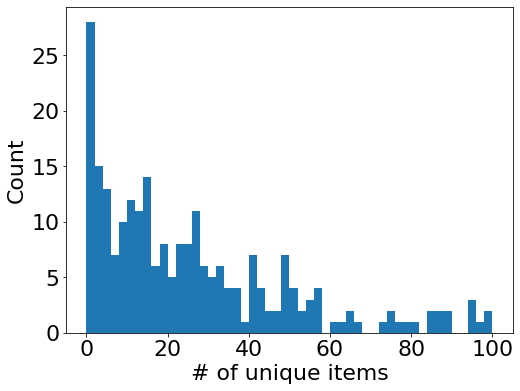

In [113]:
show_distribution(leaf_member = leaf_items)

In [106]:
# show_distribution(leaf_member = leaf_users)

# Same item in how many different leaf nodes?

mean:1.146259, std:5.084856


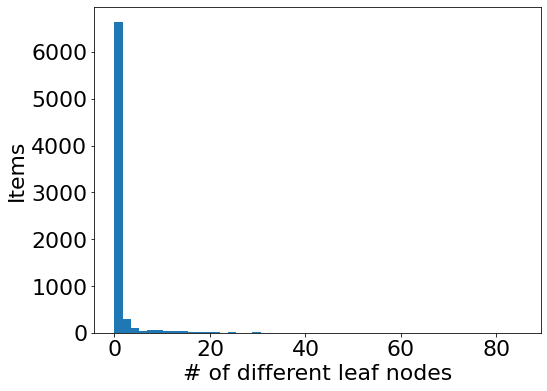

In [122]:
leaf_count_item = np.zeros(num_items)
for d in leaf_items:
    items = list(d.keys())
#     print(items)
    leaf_count_item[items] += 1
    
np.save('leaf-count-item-lastfm.npy', leaf_count_item)
leaf_count_item = np.sort(leaf_count_item)

plt.figure(figsize = (8,6))
plt.hist(leaf_count_item, bins = 50)
plt.xlabel('# of different leaf nodes')
plt.ylabel('Items')
plt.savefig('leaf_count_item-lastfm', dpi = 400)

print("mean:%f, std:%f"%(np.mean(leaf_count_item), np.std(leaf_count_item)))

# --------------------------------------------------------

In [159]:
class Model: 
    '''wrapper class'''
    def __init__(self, tree):
        self.tree = tree
        self.left = T
        
    def ask(self, node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            left -= 1
                
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  self.ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            left -= 1
                
            if(not node.neg_node.vector is None):
                return self.ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
            
    def predict(self,reviews):
        pred = []
        for r in reviews:
#             print(r, self.tree.root)
            positive_attribute, node, n_left = self.ask(node = self.tree.root, single_review = r, left = self.left)
    
            pred.append(node.vector)
        
        pred = np.array(pred)
        return pred

In [160]:
# MRR5(model = Model(forest[0]), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [161]:
# MRR5(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [163]:
DTCRS(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

78.564 8.346 0.644
75.3625 8.334 0.658
79.465 8.360666666666667 0.6476666666666666
80.7605 8.35725 0.646
79.3622 8.3732 0.6458
78.29 8.3665 0.6466666666666666
78.46514285714285 8.36042857142857 0.6482857142857142


0.6484722222222222

In [82]:
def diffnegfactCRS(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
                    su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)

In [83]:
EARLY_STOPPING = 250
ALPHA_POS = 1e0
ALPHA_NEG = 1e-2
N_MOVE_TOWARD = 10

rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()

diffnegfactCRS(forest = forest, V = V, user_interaction = val_user_interaction, reviews = val_review)
print("DONE!")

7.841 0.569
7.8205 0.574
7.889666666666667 0.5616666666666666
7.90475 0.5615
7.9198 0.5578
7.934666666666667 0.5536666666666666
7.920428571428571 0.5568571428571428
7.929444444444444 0.5565277777777777
DONE!


In [84]:
rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()



diffnegfactCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

7.818 0.584
7.809 0.5895
7.803333333333334 0.5873333333333334
7.8155 0.5885
7.8248 0.5866
7.845 0.582
7.827142857142857 0.5857142857142857
7.8220833333333335 0.5858333333333333


In [85]:
len(val_user_interaction), len(test_user_interaction)

(7200, 7200)

rec_probability at turn 1 : 0.0
rec_probability at turn 2 : 0.0
rec_probability at turn 3 : 0.39781685870224376
rec_probability at turn 4 : 0.2940374787052811
rec_probability at turn 5 : 0.9376085504342018
rec_probability at turn 6 : 0.34182509505703423
rec_probability at turn 7 : 0.2769367764915405
rec_probability at turn 8 : 0.7676001046846376
rec_probability at turn 9 : 0.9835150900329698
rec_probability at turn 10 : 1.0
rec_success at turn 3 : 0.2383130081300813
rec_success at turn 4 : 0.26998841251448435
rec_success at turn 5 : 0.2157309774864634
rec_success at turn 6 : 0.271412680756396
rec_success at turn 7 : 0.2387459807073955
rec_success at turn 8 : 0.16195022161609274
rec_success at turn 9 : 0.15807117070654977
rec_success at turn 10 : 0.11174355901737568


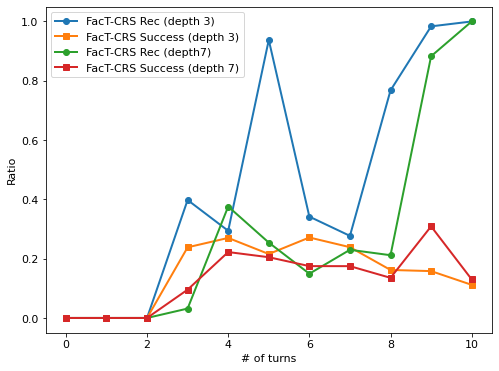

In [109]:
rec_probability = np.zeros(T+1)
for turn in range(1,T+1):
    if((rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0)) > 0):
        rec_probability[turn]  = rec_made_at.get(turn, 0)/(rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0))
        print("rec_probability at turn", turn, ":", rec_probability[turn])
        
rec_success_probability = np.zeros(T+1)
for turn in range(0,T+1):
    if((rec_made_at.get(turn, 0)) > 0):
        rec_success_probability[turn] = rec_success_at.get(turn,0)/rec_made_at.get(turn, 0)
        print("rec_success at turn", turn, ":", rec_success_probability[turn])
        
        
length = range(0,T+1)

plt.figure(figsize = (8,6))




rp7 = np.load('rec-prob-lastfm-9.npy')
rs7 = np.load('rec-succ-lastfm-9.npy')


plt.rcParams.update({'font.size': 11})


plt.plot(length,rec_probability[0:T+1], label='FacT-CRS Rec (depth 3)', marker = 'o', linewidth =2)
plt.plot(length,rec_success_probability[0:T+1], label='FacT-CRS Success (depth 3)', marker = 's', linewidth =2)

plt.plot(length,rp7[0:T+1], label='FacT-CRS Rec (depth7)', marker = 'o', linewidth =2)
plt.plot(length,rs7[0:T+1], label='FacT-CRS Success (depth 7)', marker = 's', linewidth =2)




plt.xlabel('# of turns')
plt.ylabel('Ratio')
plt.legend()
# plt.legend(loc='upper right', bbox_to_anchor=(2, 0.5))
plt.savefig('rec-succ.png',dpi = 400)

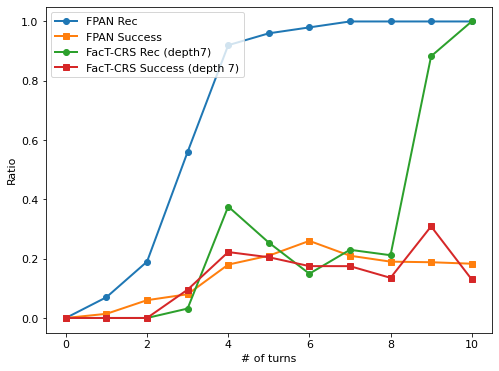

In [120]:
fpanrec = np.load('fpanrec.npy')
fpansucc = np.load('fpansucc.npy')
# plt.figure().set_size_inches(19, 13)
plt.figure(figsize = (8,6))

plt.plot(length,fpanrec, label='FPAN Rec', marker = 'o', linewidth = 2)
plt.plot(length,fpansucc, label='FPAN Success', marker = 's', linewidth = 2)

plt.plot(length,rp7[0:T+1], label='FacT-CRS Rec (depth7)', marker = 'o', linewidth = 2)
plt.plot(length,rs7[0:T+1], label='FacT-CRS Success (depth 7)', marker = 's', linewidth = 2)

plt.rcParams.update({'font.size': 11})

plt.xlabel('# of turns')
plt.ylabel('Ratio')
# plt.legend()
plt.legend(loc='upper left')
plt.savefig('rec-succ.png',dpi = 400)

# Ablation Study

In [131]:
# previously MRR10

def FacTCRS_RankingOnly(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        sulist = []
        
        already_rec = set()
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            
#             print(left)
            
            asked_tree.add(forest[next_tree])
            left-=1
            
            sulist.append(node.vector)
            su = np.mean(sulist, axis = 0)
            
            pred = -su.dot(V.T)
            sorted_list = np.argsort(pred)
#             time.sleep(1)
            kcount = 0
            recommend = []
            while(len(recommend) < topK):
                if not sorted_list[kcount] in already_rec:
                    recommend.append(sorted_list[kcount])
                    already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                kcount += 1
        
#             print("target:", i, "recommend:", recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
#                 print('success')
                success += 1
                turn_count = T - left
                break
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (forest[tree_idx] in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
        
        

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)

# FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=val_user_interaction, reviews=val_review)
FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=test_user_interaction, reviews=test_review)

7.57 0.648
7.532 0.653
7.5 0.6583333333333333
7.5145 0.65025
7.5366 0.6456
7.556166666666667 0.6415
7.543285714285714 0.6435714285714286
7.540555555555556 0.6425


In [129]:
def noEarlyRec(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= 0: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
#                     su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
noEarlyRec(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

9.673 0.415
9.6765 0.411
9.676666666666666 0.411
9.677 0.41175
9.683 0.4076
9.688833333333333 0.4021666666666667
9.682142857142857 0.4102857142857143
9.68138888888889 0.4101388888888889


In [124]:
def factCRSwithoutNeg(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
#         sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)


In [125]:
# factCRSwithoutNeg(forest = forest, V = V, user_interaction = val_user_interaction, reviews = val_review)

In [126]:
factCRSwithoutNeg(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

4.976 0.747
4.957 0.7525
4.937666666666667 0.753
4.97825 0.74775
5.0184 0.743
5.0408333333333335 0.7393333333333333
5.017 0.7421428571428571
5.019722222222223 0.7413888888888889


In [127]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()

# def varytopKCRS(forest, V, user_interaction, reviews):
    
#     topK = 50
    
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < N_TREE):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
#             left -= 1
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)

# #                 su += ALPHA_NEG* np.mean(V[idx[40:50]], axis = 0)
                    
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
    

#     print(total_turn/count, success/count)
    
# varytopKCRS(forest = forest, V = V,user_interaction = test_user_interaction[:firstr], reviews = test_review[:firstr])

In [128]:
def factCRSoneTree(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    

    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
#         sulist = []
        
        while(left > 0 and treecnt <= 1):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
factCRSoneTree(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

7.981 0.292
7.893 0.3045
7.862666666666667 0.308
7.8865 0.3045
7.9084 0.3012
7.941 0.2961666666666667
7.931571428571429 0.2975714285714286
7.922916666666667 0.2986111111111111


In [927]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()
# def factCRS(forest, V, user_interaction, reviews):
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left   
    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < N_TREE):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
            
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
#         if((count) % 1000 == 0):
# #             print(mrr/(count*treecnt), success/(count))
#             print(total_turn/count, success/count)
    
# factCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

In [ ]:
for n in range(1, 16):
    for k in range(0, n+1):
        nk_s = nk_success.get((n,k), 0)
        nk_f = nk_failed.get((n,k), 0)
        
        if((nk_s + nk_f) == 0):
            res = "null"
        else:
            res = nk_s /(nk_s + nk_f)

        print(res, end=" ")
    print()

In [200]:
def count_attributes(reviews):
    reviews = np.array(reviews)
    print(reviews.sum(axis = 1).mean(), reviews.sum(axis = 1).std())
    
count_attributes(reviews = rejected_reviews)
count_attributes(reviews = train_review)
count_attributes(reviews = train_review[successful_rid])

2.1542912246865957 1.5136728406054296
4.034853751389185 2.4605978460446605
4.02036987402841 2.474173859643712


In [202]:
def greaterThanFailed(k):
    count_all = 0
    count_rej = 0
    for r in train_review:
        if(r.sum() >= k):
            count_all += 1
    for r in rejected_reviews:
        if(r.sum() >= k):
            count_rej += 1
    return count_all, count_rej
    
greaterThanFailed(4)

(21741, 449)

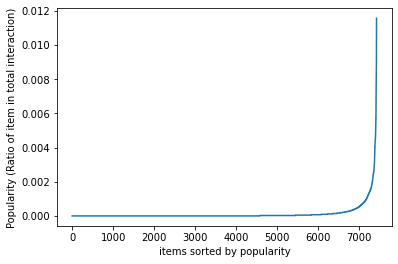

In [197]:
## item hit
rejected_uniq_items = np.unique(rejected_items)
# print(item_hit[rejected_uniq_items]).mean(), item_hit[rejected_uniq_items].std())
plt.plot(sorted(item_hit/len(train_review)))

plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
# plt.plot(sorted(item_hit[rejected_items]/len(train_review)))
# plt.show()
plt.savefig('popularity-all.png', dpi = 400)

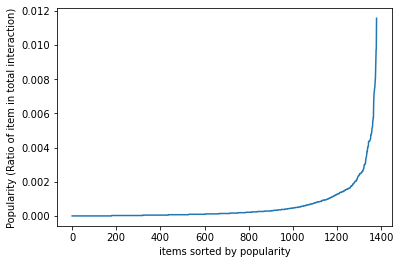

In [196]:
plt.plot(sorted(item_hit[rejected_uniq_items]/len(train_review)))
plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
plt.savefig('popularity-failed.png', dpi = 400)

In [118]:
print((sum(item_hit/len(train_review) > 0.001)) / len(item_hit))

print((sum(item_hit[rejected_uniq_items]/len(train_review) > 0.001)) / len(rejected_uniq_items))


0.03257942918686053
0.15797101449275364


# False positive and negative

In [ ]:
def count_fp_fn(node, single_review, depth, target):

    fp = False
    fn = False
    
    if(node.feature is None):
#         print("leaf node")
        return node.members, depth, node.vector, fp, fn
#     print("Q{}: {} > 0?:".format(depth+1, node.feature))   

    val = single_review[node.feature]

    if(val > 0):
#         print("yes")
        
        if(train_item_opinion[target, node.feature] <= 0 ):
            fp = True
            
        if(not node.pos_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        
    else:
#         print("no")
        if(train_item_opinion[target, node.feature] > 0 ):
            fn = True
            
        if(not node.neg_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        

In [ ]:

def total_fp_fn(reviews, interaction):
    
    success_fp = 0
    success_fn = 0

    failure_fp = 0
    failure_fn = 0

    success = 0
    
#     for r_id in range(len(reviews)):
    for r_id in range(4800):
        r = reviews[r_id]
        u, i = interaction[r_id]

        members, _, vector, fp, fn = count_fp_fn(node = review_tree.root, single_review = r, depth = 0, target = i)
        
        su = review_model.predict(r.reshape(1,-1))#??????????????????????
        pred = -su.dot(V.T)[0]
#         recommend = np.argsort(pred)
        
#         pred = -vector.dot(V.T)
        recommend = np.argpartition(pred, topK)[:topK]
        if(i in recommend): #success
            success += 1
            if(fp):
                success_fp += 1
            if(fn):
                success_fn += 1
        else: #failure
            if(fp):
                failure_fp += 1
            if(fn):
                failure_fn += 1
                
        if((r_id+1)%1000 == 0):
            print(success/(r_id+1))
    
    print(success, success_fp, success_fn, failure_fp, failure_fn)
                
total_fp_fn(reviews=test_review, interaction=test_user_interaction)

## Done

In [669]:
# SU, V = loadSUV(i=0)
# MRR1(SU = SU_new, V=V, user_interaction = train_user_interaction)
# print("-----------------------")
# MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)


In [ ]:
i = 500
V[i], V_copy[i]

In [ ]:
j = 500
SU[j], SU_new[j]

In [ ]:
saveSUV(i=1)

In [ ]:
def save_tree(i):
    with open("review_tree_{}.pkl".format(i), "wb") as f:
        pickle.dump(review_tree, f)
        
def load_tree(i):
    with open("review_tree_{}.pkl".format(i), "rb") as f:
        pickle.dump(review_tree, f)

In [ ]:
save_tree(i = 1)

In [ ]:
saveSUV(i=1)

In [ ]:
SU, _ = loadSUV(i = 1)

# ----------------------------------------------------------------

# ----------------------------------------------------------------

In [ ]:
import os.path
import time

MAX_ITER = 50
SGD_ITER = 1500

for i in range(0,MAX_ITER+1):
    
    fpath = "V_{}.npy".format(i)
    while not os.path.exists(fpath):
        print("waiting for ", fpath)
        time.sleep(60)
    if os.path.isfile(fpath):
        V = np.load('V_{}.npy'.format(i))
    else:
        raise ValueError("%s isn't a file!" % fpath)
        
    create_tree(tree_type="item", node=item_tree.root, depth=0)
    print_tree(item_tree.root, 0, 0)
    
    review_model = Model(tree = item_tree)
    SU_new, V_copy = personalize(model = item_model, num_iter = SGD_ITER)
    
    print("RESULT OF ITERATION...")
    MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)
    
    SU = SU_new
    np.save('SU_{}'.format(i), SU)
    save_tree(i = i)
    review_tree = Tree(tree_type = "review")


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [161]:
s = "this is a, string"
tokens = s.split(",")
for t in tokens:
    print(t)

this is a
 string


In [177]:
import re
re.split('\.\+', "This.is.working+maybe")

['This.is.working+maybe']

In [179]:
s = "this is a"

news = ""

for c in s:
    news = c+news

news

'a si siht'